In [7]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import scipy
import functools as ft
import random
from scipy.signal import savgol_filter as savitzky_golay

X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.identity(2)

In [8]:
qubits = 10
total_time = 20
time_step = 0.5
shots = 1000
randomness = 10

In [9]:
# Function to make hamiltonian constructing a bit easier
def get_gi(gate, i, n, get_gi1=False):
    gates = []
    for j in range(n):
        if j == i or (j == i+1 and get_gi1):
            gates.append(gate)
        else:
            gates.append(I)
    return ft.reduce(np.kron, gates)

# Creates a Hamiltonian for the Anderson model
def construct_hamiltonian(rnd, n):
    b = [random.random()*rnd for i in range(n)]
    b2 = [1 for i in range(n-1)]

    h1 = sum(b2[i]*(get_gi(X, i, n, True) + get_gi(Y, i, n, True)) for i in range(n-1))
    h2 = sum((b[i] * get_gi(Z, i, n)) for i in range(n))
    return h1 + h2

h = construct_hamiltonian(randomness, qubits)
def u(t, H=h):
    return scipy.linalg.expm(-1j * H * t)

/Users/aaronchan/miniconda3/envs/einr/lib/python3.13/site-packages/qiskit/quantum_info/operators/predicates.py:173: RuntimeWarning: divide by zero encountered in dot
  mat = np.conj(mat.T).dot(mat)
/Users/aaronchan/miniconda3/envs/einr/lib/python3.13/site-packages/qiskit/quantum_info/operators/predicates.py:173: RuntimeWarning: overflow encountered in dot
  mat = np.conj(mat.T).dot(mat)
/Users/aaronchan/miniconda3/envs/einr/lib/python3.13/site-packages/qiskit/quantum_info/operators/predicates.py:173: RuntimeWarning: invalid value encountered in dot
  mat = np.conj(mat.T).dot(mat)
/Users/aaronchan/miniconda3/envs/einr/lib/python3.13/site-packages/scipy/linalg/_matfuncs.py:373: RuntimeWarning: divide by zero encountered in matmul
  eAw = eAw @ eAw
/Users/aaronchan/miniconda3/envs/einr/lib/python3.13/site-packages/scipy/linalg/_matfuncs.py:373: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/Users/aaronchan/miniconda3/envs/einr/lib/python3.13/site-packages/scipy/linalg/_

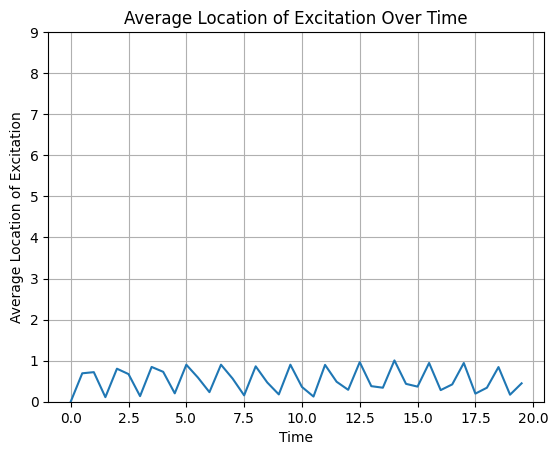

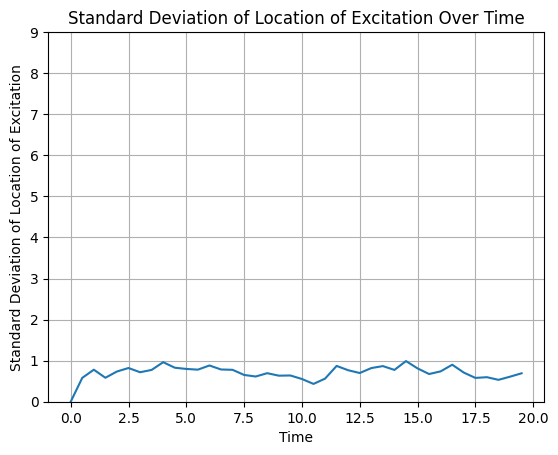

In [10]:
# Plots the variance and location of the 1 qubit as time progresses
# Low variance indicates that the 1 qubit is being localized
simulator = Aer.get_backend('aer_simulator')
r = np.arange(0, total_time, time_step)
avg_locations = []
stdevs = []

frequencies = []
      
for t in r:
    qc = QuantumCircuit(qubits)
    qc.x(0) # create state with 1 qubit in the |1> state
    qc.unitary(u(t), range(qubits))
    qc.measure_all()

    compiled_circuit = transpile(qc, simulator)
    job = simulator.run(compiled_circuit, shots=shots)
    result = job.result()
    counts = dict(result.get_counts())

    avg_location = 0
    for bitstring, freq in sorted(counts.items(), key=lambda x: x[1], reverse=True):
        location = qubits-1-bitstring.index('1')
        avg_location += location * freq / shots
        #print(f"{bitstring.replace("0", "-")}: {freq}", end='; ')
    #print(avg_location)

    variance = 0
    for bitstring, freq in sorted(counts.items(), key=lambda x: x[1], reverse=True):
        location = qubits-1-bitstring.index('1')
        variance += (location - avg_location) ** 2 * freq / shots
        frequencies.append([t, location - 0.5, freq / shots]) # subtract 0.5 to center tick marks when graphing

    avg_locations.append(avg_location)
    stdevs.append(variance ** .5)

plt.plot(r, avg_locations)
plt.xlabel('Time')
plt.ylabel('Average Location of Excitation')
plt.ylim(0, qubits-1)
plt.title('Average Location of Excitation Over Time')
plt.grid()
plt.show()

plt.plot(r, stdevs)
plt.xlabel('Time')
plt.ylabel('Standard Deviation of Location of Excitation')
plt.ylim(0, qubits-1)
plt.title('Standard Deviation of Location of Excitation Over Time')
plt.grid()
plt.show()

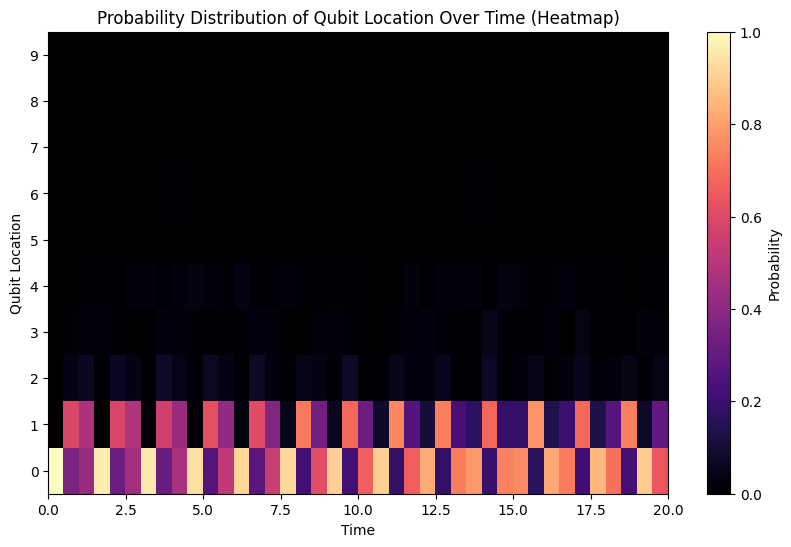

In [11]:
# Convert frequencies to numpy array for easier manipulation
freq_arr = np.array(frequencies)
locations = np.arange(-0.5, qubits-0.5, 1)
probs = freq_arr[:, 2]

# Create a 2D grid for the heatmap

heatmap = np.zeros((len(locations), len(r)))

for t, loc, p in freq_arr:
    time_idx = np.where(r == t)[0][0]
    loc_idx = np.where(locations == loc)[0][0]
    heatmap[loc_idx, time_idx] = p

plt.figure(figsize=(10, 6))
im = plt.imshow(
    heatmap,
    aspect='auto',
    origin='lower',
    cmap='magma',
    extent=[0, total_time, -.5, qubits-.5]
)
plt.colorbar(im, label='Probability')
plt.xlabel('Time')
plt.ylabel('Qubit Location')
plt.title('Probability Distribution of Qubit Location Over Time (Heatmap)')
plt.ylim(-0.5, qubits-0.5)
# show every tick on y axis
plt.yticks(np.arange(0, qubits, 1), np.arange(0, qubits, 1))

plt.grid(False)
plt.show()

In [12]:
whee error so this thing doesnt run

qbits = 9

# Returns the average variance and location of 1 for different randomness values
def anderson_random_data(hamiltonian, qubits=qbits):
    r = np.arange(0, 10, .5)
    shots = 1000
    avg_locations = []
    variances = []

    for t in r:
        qc = QuantumCircuit(qubits)
        qc.x(qbits//2) # create state with 1 qubit in the |1> state

        qc.unitary(scipy.linalg.expm(-1j * hamiltonian * t), range(qubits))
        qc.measure_all()

        compiled_circuit = transpile(qc, simulator)
        job = simulator.run(compiled_circuit, shots=shots)
        result = job.result()
        counts = dict(result.get_counts())

        avg_location = 0
        for bitstring, freq in sorted(counts.items(), key=lambda x: x[1], reverse=True):
            location = qubits-1-bitstring.index('1')
            avg_location += location * freq / shots
            #print(f"{bitstring.replace("0", "-")}: {freq}", end='; ')
        #print(avg_location)

        variance = 0
        for bitstring, freq in sorted(counts.items(), key=lambda x: x[1], reverse=True):
            location = qubits-1-bitstring.index('1')
            variance += (location - avg_location) ** 2 * freq / shots

        avg_locations.append(avg_location)
        variances.append(variance)

    return np.average(variances), np.average(avg_locations)

# Array to store the average variance and location of 1 for different randomness values

quantities_by_randomness = []
L=20
for i in np.arange(0, L, 0.4):
    H_i = construct_hamiltonian(i, n=qbits)
    quantities_by_randomness.append(anderson_random_data(H_i, qubits=qbits))

# Simple running average smoothening function to smooth the variance data, making it easer to visualize trends
def smooth(y, r):
    smooth = []
    for i in range(len(y)):
        if i < r:
            smooth.append(np.mean(y[:i+1]))
        elif i >= len(y) - r:
            smooth.append(np.mean(y[i-r:]))
        else:
            smooth.append(np.mean(y[i-r:i+r+1]))
    return np.array(smooth)

stdevs = [q[0] for q in quantities_by_randomness]
positions = [q[1] for q in quantities_by_randomness]
plt.plot(np.arange(0, L, 0.4), smooth(stdevs, 3))
plt.plot(np.arange(0, L, 0.4), smooth(positions, 3))
plt.xlabel('Randomness')
plt.ylabel('Average Variance and Location of 1')
plt.title(f'Average Variance and Location of 1 vs Randomness (qubits: {qbits}, p0 = 4)')
plt.legend(['Average Variance', 'Average Location'])
plt.grid()
plt.show()

SyntaxError: invalid syntax (995495744.py, line 1)

**Some Notes**

For systems where the 1 qubit starts from position 0, the 1 qubit very clearly becomes localized as the randomness factor (r where b = math.random()*r) increases. The graphs pretty clearly indicate this trend, as both the average position and variance decrease rapidly as the randomness increases. For 7 qubits, this factor is around 10.

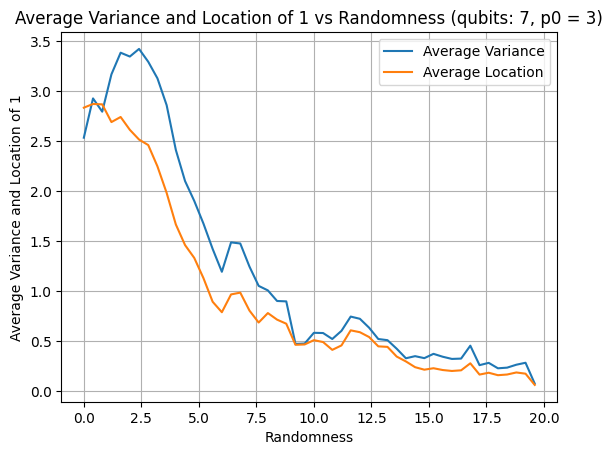

Checking for other numbers of qubits:

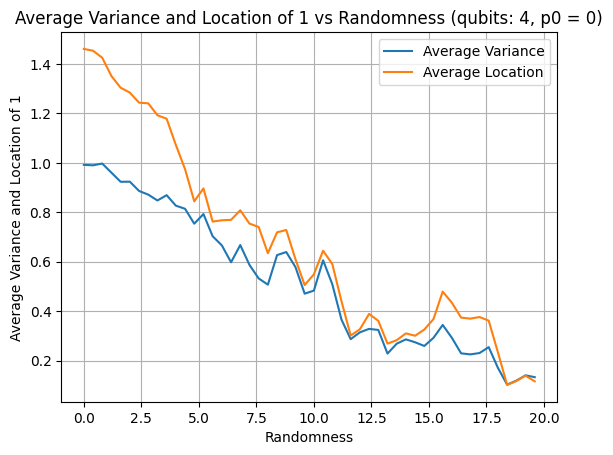 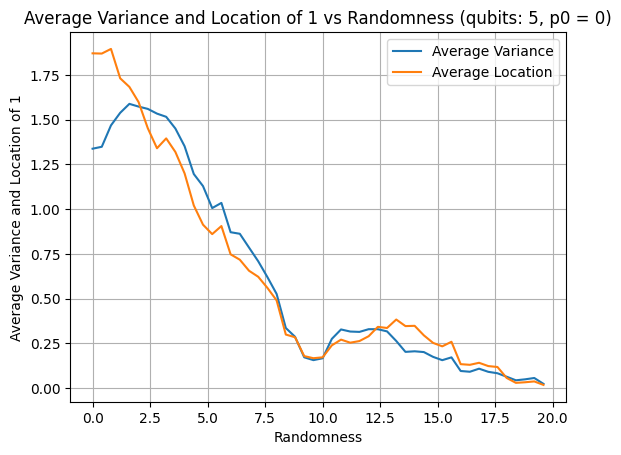 
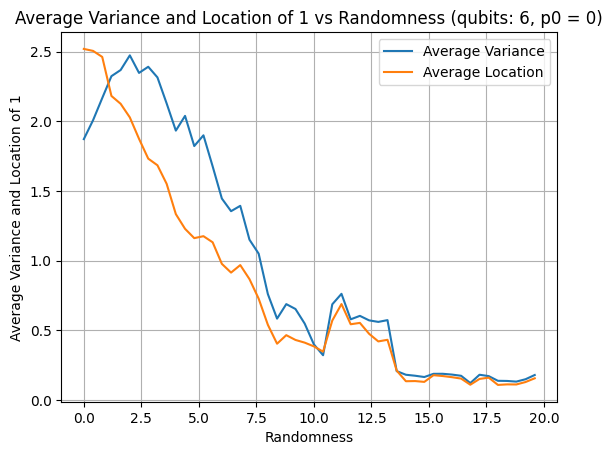 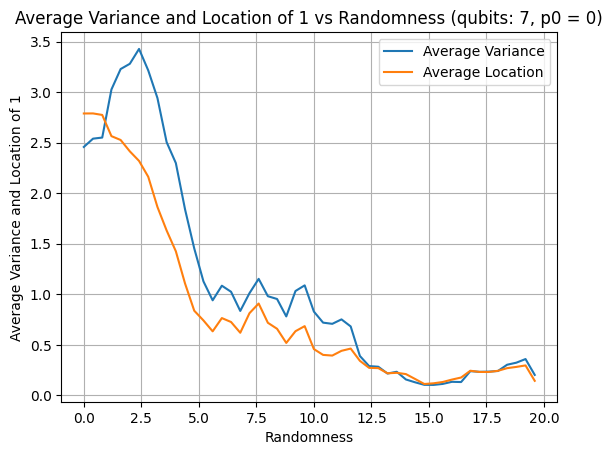
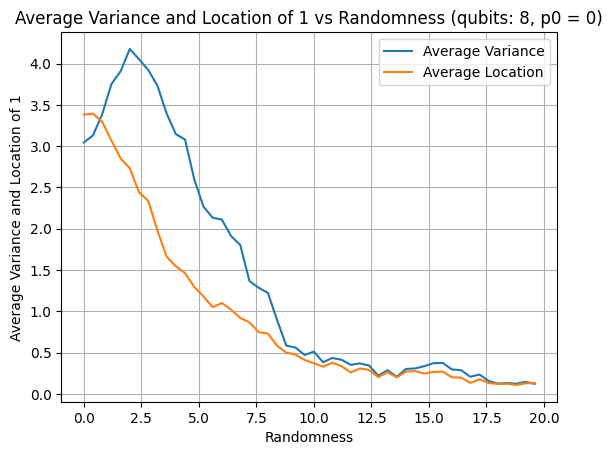 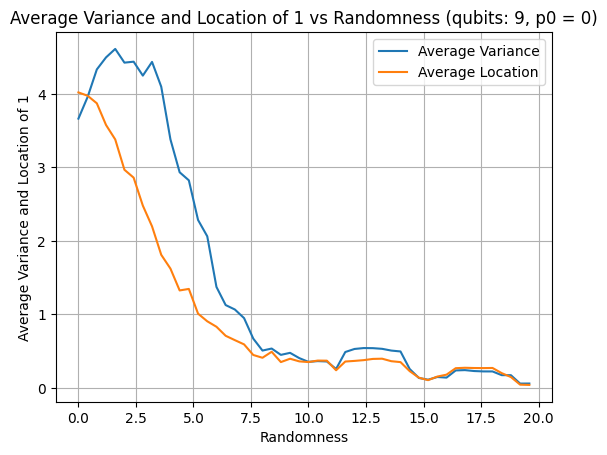

Interestingly, localization consistiently occurs around a randomness factor of 10. Also, the variance seems to increase a bit before dropping.

For systems where the 1 qubit starts at the middle of the system, the average location is in the middle regardless of the randomness factor because of symmetry. However, looking at the variance graph clearly shows that the particle still becomes localized for sufficiently large randomness factors.

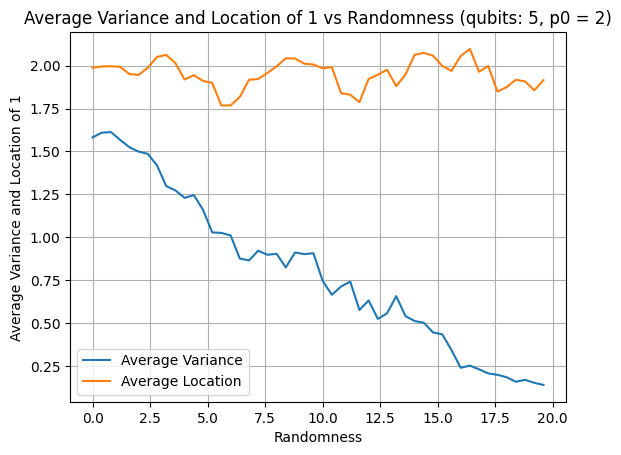 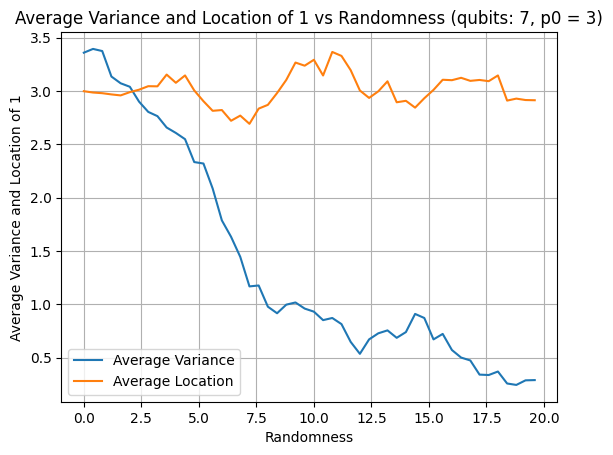
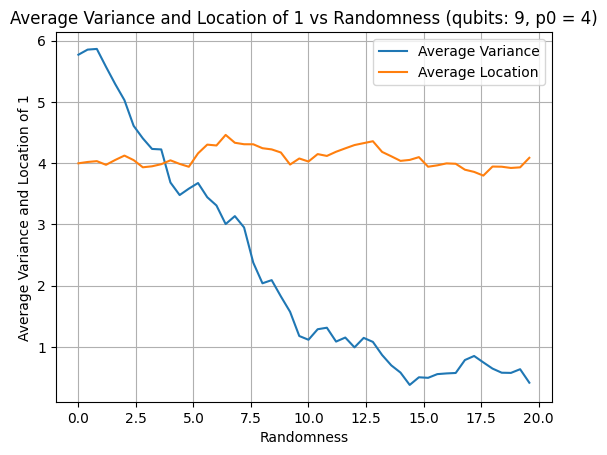

For these, the variance doesn't increase first before decreasing.